# Analyzing Fandango Movie Ratings

### Goal of this analyis: Is Fandango still inflating its movie ratings?


In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest (Fandango is an online movie ratings aggregator). He published his analysis in [this](https://fivethirtyeight.com/features/fandango-movies-ratings/) article — a great piece of data journalism that's totally worth reading.

Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars.

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

- The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
- In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
- For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

In [115]:
import pandas as pd
import numpy as np
import re
import datetime
from datetime import date

### Project Steps:

In order to understand if fandango ist still inflating ratings, I will analyze the ratings before and after Hickey's analysis. Therefore I will be comparing two datasets:

- dataset used in the analysis by Hickey: `fandango_score_comparison.csv`
- dataset with movie ratings after Hickey published his analyis: `movie_ratings_16_17.csv`

## Hickey's Dataset (2015)

In [135]:
df_previous = pd.read_csv('fandango_score_comparison.csv')
df_previous.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [136]:
df_previous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILM                        146 non-null    object 
 1   RottenTomatoes              146 non-null    int64  
 2   RottenTomatoes_User         146 non-null    int64  
 3   Metacritic                  146 non-null    int64  
 4   Metacritic_User             146 non-null    float64
 5   IMDB                        146 non-null    float64
 6   Fandango_Stars              146 non-null    float64
 7   Fandango_Ratingvalue        146 non-null    float64
 8   RT_norm                     146 non-null    float64
 9   RT_user_norm                146 non-null    float64
 10  Metacritic_norm             146 non-null    float64
 11  Metacritic_user_nom         146 non-null    float64
 12  IMDB_norm                   146 non-null    float64
 13  RT_norm_round               146 non

### Cleaning of Dataset previous to Hickey

In order to enable further analysis I'll need the following columns:

- `FILM`
- `Fandango_Stars`
- `Fandango_Ratingvalue`
- `Fandango_Votes`
- `Fandango_Difference`

I will also clean the `FILM` column by extracting the dates into a new column called year.

In [139]:
df_previous = pd.read_csv('fandango_score_comparison.csv') # read dataframe

# extract only necessary columns:
df_previous = df_previous[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']]

# rename columns:
df_previous.rename(columns = {'FILM':'film', 'Fandango_Stars':'fandango_stars', \
                               'Fandango_votes' : 'fandango_votes', \
                               'Fandango_Difference' : 'fandango_difference'}, inplace = True)

# extract date to extra column:
pattern = r'(\d{4})' # regex pattern to match year
df_previous['year'] = df_previous['film'].str.extract(pattern) # extract year to new column

# tidy up film column by getting rid of year and ()-parentheses
df_previous['film'] = (df_previous['film'].str.replace(pattern, '')
                                          .str.replace('\(\)', '')
                      )

# finally transform year to datetime format
df_previous['year'] = pd.to_datetime(df_previous['year'], format = '%Y').dt.year
df_previous.head()

,film,fandango_stars,Fandango_Ratingvalue,fandango_votes,fandango_difference,year
0,Avengers: Age of Ultron,5.0,4.5,14846,0.5,2015
1,Cinderella,5.0,4.5,12640,0.5,2015
2,Ant-Man,5.0,4.5,12055,0.5,2015
3,Do You Believe?,5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2,3.5,3.0,1021,0.5,2015


In [140]:
df_previous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   film                  146 non-null    object 
 1   fandango_stars        146 non-null    float64
 2   Fandango_Ratingvalue  146 non-null    float64
 3   fandango_votes        146 non-null    int64  
 4   fandango_difference   146 non-null    float64
 5   year                  146 non-null    int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 7.0+ KB


## Ratings in 2016 - 2017

In [141]:
df_after = pd.read_csv('movie_ratings_16_17.csv')
df_after.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


In [142]:
df_after.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movie         214 non-null    object 
 1   year          214 non-null    int64  
 2   metascore     214 non-null    int64  
 3   imdb          214 non-null    float64
 4   tmeter        214 non-null    int64  
 5   audience      214 non-null    int64  
 6   fandango      214 non-null    float64
 7   n_metascore   214 non-null    float64
 8   n_imdb        214 non-null    float64
 9   n_tmeter      214 non-null    float64
 10  n_audience    214 non-null    float64
 11  nr_metascore  214 non-null    float64
 12  nr_imdb       214 non-null    float64
 13  nr_tmeter     214 non-null    float64
 14  nr_audience   214 non-null    float64
dtypes: float64(10), int64(4), object(1)
memory usage: 25.2+ KB


### Cleaning Dataframe containing Movie Ratings after Hickey Analysis

The dataframe is in pretty good shape, I'll just select columns that are necessary for the analysis which are:
- `movie`
- `year`
- `fandango`


In [143]:
df_after = pd.read_csv('movie_ratings_16_17.csv')
df_after = df_16_17[['movie', 'year', 'fandango']]
df_after.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


In [144]:
df_after.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   movie     214 non-null    object 
 1   year      214 non-null    int64  
 2   fandango  214 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.1+ KB


Our goal is to determine whether there has been any change in Fandango's rating system after Hickey's analysis. The population of interest for our analysis is made of all the movie ratings stored on Fandango's website, regardless of the releasing year.

Because we want to find out whether the parameters of this population changed after Hickey's analysis, we're interested in sampling the population at two different periods in time — previous and after Hickey's analysis — so we can compare the two states.

The data we're working with was sampled at the moments we want: one sample was taken previous to the analysis, and the other after the analysis. We want to describe the population, so we need to make sure that the samples are representative, otherwise we should expect a large sampling error and, ultimately, wrong conclusions.

From Hickey's article and from the `README.md` of the data set's repository, we can see that he used the following sampling criteria:

- The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
- The movie must have had tickets on sale in 2015.

The sampling was clearly not random because not every movie had the same chance to be included in the sample — some movies didn't have a chance at all (like those having under 30 fan ratings or those without tickets on sale in 2015). It's questionable whether this sample is representative of the entire population we're interested to describe. It seems more likely that it isn't, mostly because this sample is subject to temporal trends — e.g. movies in 2015 might have been outstandingly good or bad compared to other years.

The sampling conditions for our other sample were (as it can be read in the `README.md` of the data set's repository):

- The movie must have been released in 2016 or later.
- The movie must have had a considerable number of votes and reviews (unclear how many from the README.md or from the data).
This second sample is also subject to temporal trends and it's unlikely to be representative of our population of interest.

Both these authors had certain research questions in mind when they sampled the data, and they used a set of criteria to get a sample that would fit their questions. Their sampling method is called purposive sampling (or judgmental/selective/subjective sampling). While these samples were good enough for their research, they don't seem too useful for us.

## Changing the Goal of our Analysis
At this point, we can either collect new data or change our the goal of our analysis. We choose the latter and place some limitations on our initial goal.

Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should also be a fairly good proxy for our initial goal.

## Isolating the Samples We Need
With this new research goal, we have two populations of interest:

1. All Fandango's ratings for popular movies released in 2015.
2. All Fandango's ratings for popular movies released in 2016.

We need to be clear about what counts as popular movies. We'll use Hickey's benchmark of 30 fan ratings and count a movie as popular only if it has 30 fan ratings or more on Fandango's website.

Although one of the sampling criteria in our second sample is movie popularity, the sample doesn't provide information about the number of fan ratings. We should be skeptical once more and ask whether this sample is truly representative and contains popular movies (movies with over 30 fan ratings).

One quick way to check the representativity of this sample is to sample randomly 10 movies from it and then check the number of fan ratings ourselves on Fandango's website. Ideally, at least 8 out of the 10 movies have 30 fan ratings or more.

In [145]:
df_after.sample(10, random_state = 1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


The sampled movies above check out!

### Separating by date:
To enable final analysis I will need to: 
- Isolate the movies released in 2015 in a separate data set.
- Isolate the movies released in 2016 in another separate data set.
- These are the data sets we'll use next to perform our analysis.

#### Previous Data Set

In [146]:
df_previous['year'].value_counts()

2015    129
2014     17
Name: year, dtype: int64

In [147]:
df_2015 = df_previous[df_previous['year'] == 2015].copy()
df_2015['year'].value_counts()

2015    129
Name: year, dtype: int64

In [148]:
df_2015.head()

,film,fandango_stars,Fandango_Ratingvalue,fandango_votes,fandango_difference,year
0,Avengers: Age of Ultron,5.0,4.5,14846,0.5,2015
1,Cinderella,5.0,4.5,12640,0.5,2015
2,Ant-Man,5.0,4.5,12055,0.5,2015
3,Do You Believe?,5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2,3.5,3.0,1021,0.5,2015


#### After Data Set

In [149]:
df_after['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [150]:
df_2016 = df_after[df_after['year'] == 2016].copy()
df_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

In [151]:
df_2016.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
4,A Hologram for the King,2016,3.0
5,A Monster Calls,2016,4.0


## Actual Data Analyis:
#### Density Distribution plots for 2015 and 2016

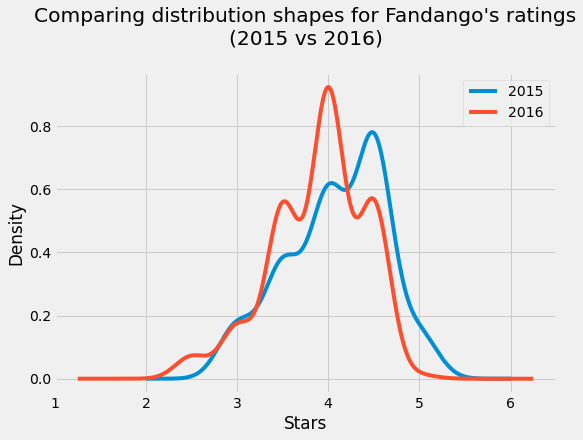

In [152]:
import matplotlib.pyplot as plt
from numpy import arange
%matplotlib inline

plt.style.use('fivethirtyeight')
df_2015['fandango_stars'].plot.kde(label='2015', legend = True, figsize = (8,5.5))
df_2016['fandango'].plot.kde(label='2016', legend = True, figsize = (8,5.5))
plt.title("Comparing distribution shapes for Fandango's ratings\n(2015 vs 2016)",
          y = 1.07) # the `y` parameter pads the title upward
plt.xlabel('Stars')
plt.show()

Two aspects are striking on the figure above:

- Both distributions are strongly left skewed.
- The 2016 distribution is slightly shifted to the left relative to the 2015 distribution.

The left skew suggests that movies on Fandango are given mostly high and very high fan ratings. Coupled with the fact that Fandango sells tickets, the high ratings are a bit dubious. It'd be really interesting to investigate this further — ideally in a separate project, since this is quite irrelevant for the current goal of our analysis.

The slight left shift of the 2016 distribution is very interesting for our analysis. It shows that ratings were slightly lower in 2016 compared to 2015. This suggests that there was a difference indeed between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We can also see the direction of the difference: the ratings in 2016 were slightly lower compared to 2015.



## Comparison of relative Frequency Tables

- both samples have different amounts of movies
- therefore it is better to use relative frequencies

In [153]:
print('2015 \n'  + '-' * 16)
df_2015['fandango_stars'].value_counts(normalize = True).sort_index() * 100

2015 
----------------


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: fandango_stars, dtype: float64

In [154]:
print('2016 \n'  + '-' * 16)
df_2016['fandango'].value_counts(normalize = True).sort_index() * 100

2016 
----------------


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

In 2016, very high ratings (4.5 and 5 stars) had significantly lower percentages compared to 2015. In 2016, under 1% of the movies had a perfect rating of 5 stars, compared to 2015 when the percentage was close to 7%. Ratings of 4.5 were also more popular in 2015 — there were approximately 13% more movies rated with a 4.5 in 2015 compared to 2016.

The minimum rating is also lower in 2016 — 2.5 instead of 3 stars, the minimum of 2015. There clearly is a difference between the two frequency distributions.

For some other ratings, the percentage went up in 2016. There was a greater percentage of movies in 2016 that received 3.5 and 4 stars, compared to 2015. 3.5 and 4.0 are high ratings and this challenges the direction of the change we saw on the kernel density plots.

## Direction of Change

In [155]:
# mean
mean_2015 = df_2015['fandango_stars'].mean()
mean_2016 = df_2016['fandango'].mean()

# median
median_2015 = df_2015['fandango_stars'].median()
median_2016 = df_2016['fandango'].median()

# mode
mode_2015 = df_2015['fandango_stars'].mode()[0]
mode_2016 = df_2016['fandango'].mode()[0]

summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


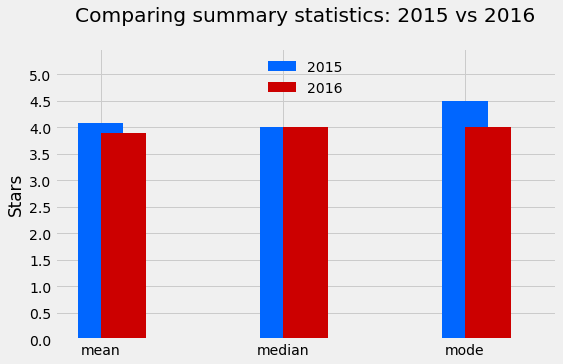

In [156]:
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(color = '#0066FF', align = 'center', label = '2015', width = .25)
summary['2016'].plot.bar(color = '#CC0000', align = 'edge', label = '2016', width = .25,
                         rot = 0, figsize = (8,5))

plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.07)
plt.ylim(0,5.5)
plt.yticks(arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()

The mean rating was lower in 2016 with approximately 0.2. This means a drop of almost 5% relative to the mean rating in 2015.

In [157]:
(summary.loc['mean'][0] - summary.loc['mean'][1]) / summary.loc['mean'][0]

0.04842683568951993

# Conclusion
In this analysis I was able to show that there's indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. I also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.

We cannot be completely sure what caused the change, but the chances are very high that it was caused by Fandango fixing the biased rating system after Hickey's analysis.